In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_validate 
from sklearn import metrics

In [3]:
df = pd.read_csv("../data/clean/full_set.csv")

# drop time related features
df.drop(["Time","MidPeriod","year"], axis=1, inplace=True)

# drop country identifying features
df.drop(["Country","country","LocID","Code"], axis=1, inplace=True)

# drop highly correlated variables (to RelMigrations)
df.drop(["CNMR","NetMigrations"], axis=1, inplace=True)

# drop other unwanted columns
df.drop(["change_from_previous_year","Unnamed: 0"], axis=1, inplace=True)

In [4]:
df.head(2)

,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,IMR,Q5,CDR,...,group_grievance,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention
0,6.478,2.666,42.513,0.042049,59.63,58.34,61.02,72.193,100.008,9.124,...,9.5,8.5,8.1,7.0,9.2,8.3,8.4,9.1,8.9,10.0
1,5.447,2.319,37.098,0.036558,62.32,60.93,63.79,60.100,81.042,7.498,...,9.2,8.2,7.8,7.2,9.4,8.8,8.4,9.3,9.2,10.0


# Create target class

In [5]:
df.RelMigrations.hist()

In [26]:
conditions = [
    (df['RelMigrations'] >= 0.03),
    (df['RelMigrations'] < 0.03)]
choices = ['high_migration', 'low_migration']
df['migration_rank'] = np.select(conditions, choices, default='low_migration')

In [27]:
df.migration_rank.value_counts()

low_migration     453
high_migration     10
Name: migration_rank, dtype: int64

In [28]:
total_low_migration = df.migration_rank.value_counts()["low_migration"]
total_high_migration = df.migration_rank.value_counts()["high_migration"]

In [29]:
X = df.drop(["RelMigrations","migration_rank"], axis=1)
y = df.migration_rank

# Scoring

In [30]:
def f1_scorer(classifier, X, y):
    y_pred = classifier.predict(X)
    f1 = metrics.f1_score(y, y_pred, average="weighted")
    return f1

In [31]:
def precision_scorer(classifier, X, y):
    y_pred = classifier.predict(X)
    precision = metrics.precision_score(y, y_pred, average="weighted")
    return precision

In [32]:
def recall_scorer(classifier, X, y):
    y_pred = classifier.predict(X)
    recall = metrics.recall_score(y, y_pred, average="weighted")
    return recall

In [33]:
def confusion_scorer_low(classifier, X, y):
    y_pred = classifier.predict(X)
    m = metrics.confusion_matrix(y, y_pred, labels=["low_migration","high_migration"])
    return m[0][1]

In [34]:
def confusion_scorer_high(classifier, X, y):
    y_pred = classifier.predict(X)
    m = metrics.confusion_matrix(y, y_pred, labels=["low_migration","high_migration"])
    return m[1][0]

In [35]:
scoring = {"f1":f1_scorer, "precision":precision_scorer, "recall":recall_scorer, 
           "wrong_high_migration":confusion_scorer_high, "wrong_low_migration":confusion_scorer_low}

In [36]:
def do_crossval(X, y, classifier):
    scores = cross_validate(classifier, X, y, cv=10, n_jobs=-1, scoring=scoring, return_train_score=False)
    
    precision = round(scores["test_precision"].mean(), 3)
    recall = round(scores["test_recall"].mean(), 3)
    f1 = round(scores["test_f1"].mean(), 3)
    confusion_high = round(scores["test_wrong_high_migration"].sum(), 3)
    confusion_low = round(scores["test_wrong_low_migration"].sum(), 3)
    
    return precision, recall, f1, confusion_high, confusion_low

# Random Forest

In [37]:
precision, recall, f1, confusion_high, confusion_low = do_crossval(X, y, RandomForestClassifier(n_estimators=1000, 
                                                                                                class_weight="balanced"))
print("precision: " + str(precision) + 
      "\nrecall: " + str(recall) +
      "\nf1_score: " + str(f1) + 
      "\nmissclassification rate for high migration cases: " + str(round(confusion_high / total_high_migration * 100, 2)) + "%" +
      "\nmissclassification rate for low migration cases: " + str(round(confusion_low / total_low_migration * 100, 2)) + "%"
     )

precision: 0.978
recall: 0.987
f1_score: 0.982
missclassification rate for high migration cases: 50.0%
missclassification rate for low migration cases: 0.22%


In [38]:
rf_feature_importances = pd.DataFrame(RandomForestClassifier(n_estimators=1000, class_weight="balanced").fit(X,y).feature_importances_).T
rf_feature_importances.columns = X.columns
rf_feature_importances = rf_feature_importances.T
rf_feature_importances.columns = ["importance"]
rf_feature_importances.sort_values(by="importance", ascending=False)

,importance
GrowthRate,0.167891
DeathsMale,0.109744
Deaths,0.107242
DeathsFemale,0.101462
CDR,0.084699
PopMale_20-59,0.065214
PopTotal_20-59,0.062389
PopFemale,0.044566
PopMale,0.043758
LExMale,0.026910


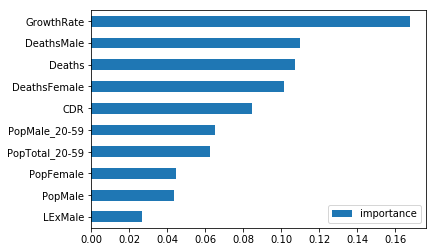

In [39]:
rf_feature_importances.sort_values(by="importance", ascending=True)[-10:].plot(kind="barh")

# Ridge

In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
precision, recall, f1, confusion_high, confusion_low = do_crossval(MinMaxScaler().fit_transform(X), y, RidgeClassifier(normalize=True, class_weight="balanced"))
print("precision: " + str(precision) + 
      "\nrecall: " + str(recall) +
      "\nf1_score: " + str(f1) + 
      "\nmissclassification rate for high migration cases: " + str(round(confusion_high / total_high_migration * 100, 2)) + "%" +
      "\nmissclassification rate for low migration cases: " + str(round(confusion_low / total_low_migration * 100, 2)) + "%"
     )

precision: 0.986
recall: 0.957
f1_score: 0.968
missclassification rate for high migration cases: 10.0%
missclassification rate for low migration cases: 4.19%


C:\Anaconda\envs\fastaienv\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [44]:
ridge_feature_importances = pd.DataFrame(RidgeClassifier(normalize=True, class_weight="balanced").fit(MinMaxScaler().fit_transform(X),y).coef_)
ridge_feature_importances.columns = X.columns
ridge_feature_importances = ridge_feature_importances.T
ridge_feature_importances.columns = ["importance"]
ridge_feature_importances = ridge_feature_importances.round(3)
ridge_feature_importances.sort_values(by="importance", ascending=False)

C:\Anaconda\envs\fastaienv\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,importance
DeathsMale,0.304
Deaths,0.286
CDR,0.278
DeathsFemale,0.265
PopTotal,0.244
PopMale_60+,0.233
PopTotal_60+,0.225
PopFemale_60+,0.214
economic_inequality,0.212
economy,0.205


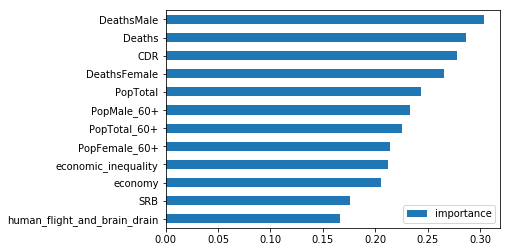

In [49]:
ridge_feature_importances.sort_values(by="importance", ascending=True)[-12:].plot(kind="barh")